# Detection of Fraud Reviews: Exploratory Data Analysis

## Loading libraries

In [5]:
!pip install demoji
!pip install wordcloud

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
import seaborn as sns

# Pre-processing
import re
import nltk
import demoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to C:\Users\PC CUA
[nltk_data]     DIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\PC CUA
[nltk_data]     DIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\PC CUA
[nltk_data]     DIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

## Reading datasets

### Fake Reviews dataset

In [9]:
# Path to your CSV file
fake_reviews_path = r'H:\BT4012\Fake-Reviews-Detection\Dataset\fake reviews dataset.csv'
fake_reviews_path_drive = '/content/drive/MyDrive/fake reviews dataset.csv'

# Read the CSV file
fake_reviews_df = pd.read_csv(fake_reviews_path)

In [10]:
fake_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [11]:
fake_reviews_df.shape

(40432, 4)

In [12]:
fake_reviews_df.columns

Index(['category', 'rating', 'label', 'text_'], dtype='object')

In [13]:
fake_reviews_df['rating'] = fake_reviews_df['rating'].astype('int')

In [14]:
# Display the first few rows
fake_reviews_df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


### Yelp dataset

In [15]:
# Path to your Excel file
yelp_path = r'H:\BT4012\Fake-Reviews-Detection\Dataset\Yelp Labelled Review Dataset with Sentiments and Features.xlsx'
yelp_path_drive = '/content/drive/MyDrive/Yelp Labelled Review Dataset with Sentiments and Features.xlsx'

# Read the Excel file
yelp_df = pd.read_excel(yelp_path, engine='openpyxl')

In [16]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355210 entries, 0 to 355209
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   User_id                  355210 non-null  int64         
 1   Product_id               355210 non-null  int64         
 2   Rating                   355210 non-null  int64         
 3   Date                     355210 non-null  datetime64[ns]
 4   Review                   355210 non-null  object        
 5   Spam(1) and Not Spam(0)  355210 non-null  int64         
 6   Sentiment                355210 non-null  object        
 7   Features                 355210 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 21.7+ MB


In [17]:
yelp_df.shape

(355210, 8)

In [18]:
yelp_df.columns

Index(['User_id', 'Product_id', 'Rating', 'Date', 'Review',
       'Spam(1) and Not Spam(0)', 'Sentiment', 'Features'],
      dtype='object')

In [19]:
yelp_df.rename(columns={'Spam(1) and Not Spam(0)':'Spam'}, inplace=True)

In [20]:
# Display the first few rows
yelp_df.head()

,User_id,Product_id,Rating,Date,Review,Spam,Sentiment,Features
0,923,0,3,2014-01-30,The food at snack is a selection of popular Gr...,1,Positive,"['appetizer tray', 'greek salad', 'main courses']"
1,924,0,3,2011-05-05,This little place in Soho is wonderful. I had ...,1,Positive,"['little place', 'soho', 'lamb sandwich', 'soh..."
2,925,0,4,2011-12-30,ordered lunch for 15 from Snack last Friday. Ã...,1,Positive,"['snack', 'regular company lunch list']"
3,926,0,4,2012-10-04,This is a beautiful quaint little restaurant o...,1,Positive,"['beautiful quaint', 'pretty street', 'great p..."
4,927,0,4,2014-02-06,Snack is great place for a Ã‚Â casual sit down...,1,Positive,"['snack', 'great place', 'Ã¢ casual', 'cold wi..."


## Check for missing values

### Fake Reviews dataset

In [21]:
# Check for missing values
fake_reviews_df.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

### Yelp dataset

In [22]:
# Check for missing values
yelp_df.isnull().sum()

User_id       0
Product_id    0
Rating        0
Date          0
Review        0
Spam          0
Sentiment     0
Features      0
dtype: int64

## Check for duplicated values

### Fake Reviews dataset

In [23]:
fake_reviews_df_duplicates = fake_reviews_df.duplicated().sum()

print("Number of duplicates in dataset:", fake_reviews_df_duplicates)

Number of duplicates in dataset: 12


**Drop the duplicate rows**

In [24]:
# Drop duplicates while keeping the first occurrence
fake_reviews_df = fake_reviews_df.drop_duplicates()

# Check the new count of duplicates to confirm removal
print("Number of duplicates after dropping: ", fake_reviews_df.duplicated().sum())

Number of duplicates after dropping:  0


### Yelp dataset

In [25]:
yelp_df_duplicates = yelp_df.duplicated().sum()

print("Number of duplicates in dataset: ", yelp_df_duplicates)

Number of duplicates in dataset:  0


## Describing dataset

### Fake Reviews dataset

In [26]:
fake_reviews_df.describe()

,rating
count,40420.000000
mean,4.256358
std,1.144452
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Yelp dataset

In [27]:
yelp_df.describe()

,User_id,Product_id,Rating,Date,Spam
count,355210.000000,355210.000000,355210.000000,355210,355210.000000
mean,54016.107489,460.646674,3.604355,2012-11-30 06:17:35.037865216,0.101723
min,923.000000,0.000000,1.000000,2011-03-01 00:00:00,0.000000
25%,13834.000000,247.000000,3.000000,2012-01-16 00:00:00,0.000000
50%,40531.500000,468.000000,4.000000,2012-11-30 00:00:00,0.000000
75%,87641.000000,672.000000,5.000000,2013-10-16 00:00:00,0.000000
max,161147.000000,922.000000,5.000000,2014-08-31 00:00:00,1.000000
std,45871.499377,260.531902,1.365950,NaN,0.302284


## Distribution of ratings

In [28]:
# Count the occurrences in each dataset
ratings_fake = fake_reviews_df['rating'].value_counts().reset_index()
ratings_yelp = yelp_df['Rating'].value_counts().reset_index()

# Rename columns for merging
ratings_fake.rename(columns={'rating':'Rating'}, inplace=True)

ratings_fake['Dataset'] = 'Fake Reviews'
ratings_yelp['Dataset'] = 'Yelp'

# Combine counts into a single DataFrame for plotting
ratings_counts = pd.concat([ratings_fake, ratings_yelp])

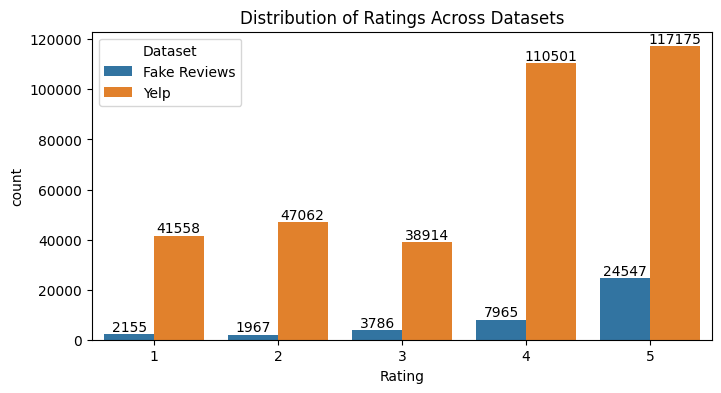

In [29]:
# Plot using Seaborn for a grouped bar chart
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Rating', y='count', hue='Dataset', data=ratings_counts)

# Add count annotations on top of each bar
for container in ax.containers:
    ax.bar_label(container)

# Add title and labels
ax.set_title('Distribution of Ratings Across Datasets')
plt.show()

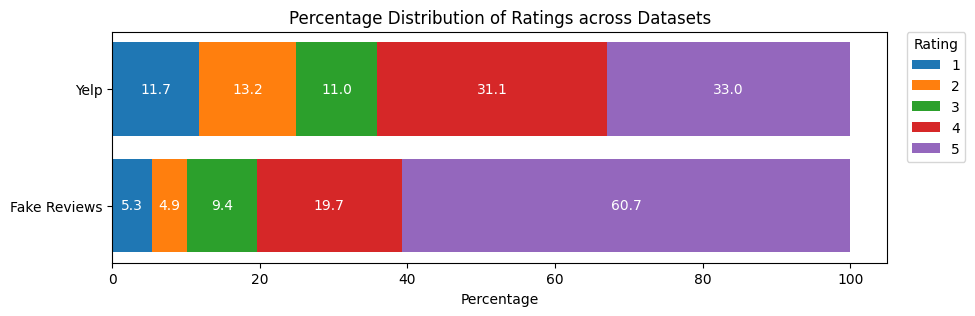

In [30]:
# Calculate total counts for each dataset
ratings_counts['Total'] = ratings_counts.groupby('Dataset')['count'].transform('sum')

# Calculate percentage for each rating within each dataset
ratings_counts['Percentage'] = (ratings_counts['count'] / ratings_counts['Total']) * 100

# Pivot the data to get the percentage for each rating as a stacked bar
pivot_ratings = ratings_counts.pivot(index='Dataset', columns='Rating', values='Percentage').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 3))

# Bottom placeholder for stacking
bottom = [0] * len(pivot_ratings)

# Plot each rating as a segment in the stacked bar chart
for rating in pivot_ratings.columns:
    bars = ax.barh(pivot_ratings.index, pivot_ratings[rating], left=bottom, label=f'{rating}')
    # Annotate percentages on each bar
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            ax.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:.1f}',
                ha='center', va='center', color='white'
            )
    # Update bottom for stacking
    bottom = [i + j for i, j in zip(bottom, pivot_ratings[rating])]

# Add title and labels
ax.set_title('Percentage Distribution of Ratings across Datasets')
ax.set_xlabel('Percentage')
ax.legend(title='Rating', bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.show()

## Distribution of target variable

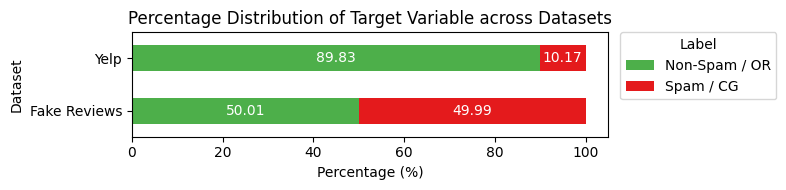

In [31]:
# Step 1: Count spam and non-spam for Fake Reviews
spam_counts_fake = fake_reviews_df['label'].value_counts().reset_index()
spam_counts_fake.columns = ['Label', 'Count']
spam_counts_fake['Label'] = spam_counts_fake['Label'].map({'OR': 'Non-Spam / OR', 'CG': 'Spam / CG'})  # Map labels
spam_counts_fake['Dataset'] = 'Fake Reviews'

# Step 2: Count spam and non-spam for Yelp
spam_counts_yelp = yelp_df['Spam'].value_counts().reset_index()
spam_counts_yelp.columns = ['Label', 'Count']
spam_counts_yelp['Label'] = spam_counts_yelp['Label'].map({0: 'Non-Spam / OR', 1: 'Spam / CG'})  # Map labels
spam_counts_yelp['Dataset'] = 'Yelp'

# Step 3: Combine counts into a single DataFrame
spam_counts = pd.concat([spam_counts_fake, spam_counts_yelp])

# Step 4: Calculate total counts for percentage
spam_counts['Total'] = spam_counts.groupby('Dataset')['Count'].transform('sum')
spam_counts['Percentage'] = (spam_counts['Count'] / spam_counts['Total']) * 100

# Step 5: Pivot the data for plotting
spam_counts_pivot = spam_counts.pivot(index='Dataset', columns='Label', values='Percentage').fillna(0)

# Step 6: Plot the data
ax = spam_counts_pivot.plot(kind='barh', stacked=True, figsize=(8, 2), color=['#4DAF4A', '#E41A1C'])

# Set labels and title
plt.xlabel('Percentage (%)')
plt.title('Percentage Distribution of Target Variable across Datasets')
plt.legend(title='Label', bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=0)

# Annotate the bars with percentage values
for i in range(len(spam_counts_pivot)):
    total_width = spam_counts_pivot.iloc[i].sum()
    for j, value in enumerate(spam_counts_pivot.iloc[i]):
        if value > 0:  # Only annotate if the value is greater than 0
            ax.text(value / 2 + (spam_counts_pivot.iloc[i][:j].sum() if j > 0 else 0),
                     i,
                     f"{value:.2f}",
                     ha='center',
                     va='center',
                     color='white')
plt.tight_layout()

# Show the plot
plt.show()

## Graphs between ratings and target variable

### Distribution of target variable by ratings

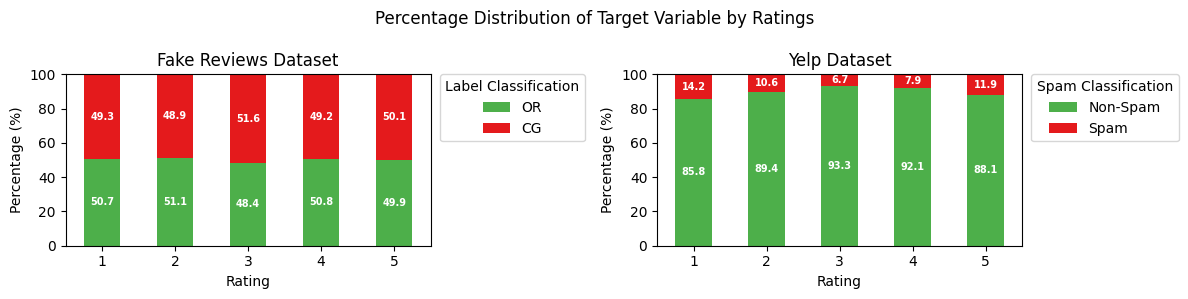

In [32]:
# Calculate count of ratings by label for Fake Reviews
fake_counts = fake_reviews_df.groupby(['rating', 'label']).size().reset_index(name='count')

# Calculate the total count of each rating for percentage
total_fake = fake_counts.groupby('rating')['count'].transform('sum')
fake_counts['percentage'] = (fake_counts['count'] / total_fake) * 100

# Pivot the table for plotting
fake_counts_pivot = fake_counts.pivot(index='rating', columns='label', values='percentage').fillna(0)

# Set the order of the labels to ensure 'OR' is below 'CG'
fake_counts_pivot = fake_counts_pivot[['OR', 'CG']]

# Calculate count of ratings by Spam classification for Yelp
yelp_counts = yelp_df.groupby(['Rating', 'Spam']).size().reset_index(name='count')

# Calculate the total count of each rating for percentage
total_yelp = yelp_counts.groupby('Rating')['count'].transform('sum')
yelp_counts['percentage'] = (yelp_counts['count'] / total_yelp) * 100

# Pivot the table for plotting
yelp_counts_pivot = yelp_counts.pivot(index='Rating', columns='Spam', values='percentage').fillna(0)
yelp_counts_pivot.columns = ['Non-Spam', 'Spam']  # Rename columns for clarity

# Set up the plot for both datasets
plt.figure(figsize=(12, 3))
plt.suptitle("Percentage Distribution of Target Variable by Ratings")

# Create a stacked bar chart for Fake Reviews
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
fake_counts_pivot.plot(kind='bar', stacked=True, color=['#4DAF4A', '#E41A1C'], ax=plt.gca())
plt.title("Fake Reviews Dataset")
plt.xlabel("Rating")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.legend(title='Label Classification', bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)

# Add percentage annotations for Fake Reviews
for i in range(len(fake_counts_pivot)):
    for j, value in enumerate(fake_counts_pivot.iloc[i]):
        if value > 0:  # Only annotate if the value is greater than 0
            plt.annotate(f"{value:.1f}",
                         (i, value / 2 + (fake_counts_pivot.iloc[i][:j].sum() if j > 0 else 0)),
                         ha='center', va='center', color='white', fontsize=7, weight='bold')

# Create a stacked bar chart for Yelp Dataset
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
yelp_counts_pivot.plot(kind='bar', stacked=True, color=['#4DAF4A', '#E41A1C'], ax=plt.gca())
plt.title("Yelp Dataset")
plt.xlabel("Rating")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.legend(title='Spam Classification', bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)

# Add percentage annotations for Yelp Dataset
for i in range(len(yelp_counts_pivot)):
    for j, value in enumerate(yelp_counts_pivot.iloc[i]):
        if value > 0:  # Only annotate if the value is greater than 0
            plt.annotate(f"{value:.1f}",
                         (i, value / 2 + (yelp_counts_pivot.iloc[i][:j].sum() if j > 0 else 0)),
                         ha='center', va='center', color='white', fontsize=7, weight='bold')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Distribution of ratings by target variable

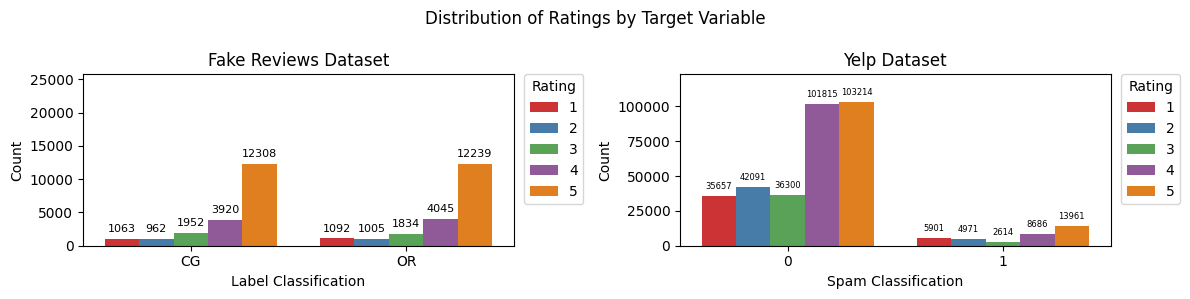

In [33]:
# Set up the plot for both datasets
plt.figure(figsize=(12, 3))
plt.suptitle("Distribution of Ratings by Target Variable")

# Create a countplot for Fake Reviews by Target Variable
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.countplot(x='label', hue='rating', data=fake_reviews_df, palette='Set1')
plt.title("Fake Reviews Dataset")
plt.xlabel("Label Classification")
plt.ylabel("Count")
plt.legend(title='Rating', bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.ylim(0, fake_reviews_df['rating'].value_counts().max() * 1.05)

# Add annotations for Fake Reviews, only if height > 0
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:  # Only annotate if height is greater than zero
        plt.annotate(f'{height:.0f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='baseline', fontsize=8,
                     color='black', xytext=(0, 5),
                     textcoords='offset points')

# Create a countplot for Yelp Dataset by Target Variable
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.countplot(x='Spam', hue='Rating', data=yelp_df, palette='Set1')
plt.title("Yelp Dataset")
plt.xlabel("Spam Classification")
plt.ylabel("Count")
plt.legend(title='Rating', bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0)
plt.ylim(0, yelp_df['Rating'].value_counts().max() * 1.05)

# Add annotations for Yelp Dataset, only if height > 0
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:  # Only annotate if height is greater than zero
        plt.annotate(f'{height:.0f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='baseline', fontsize=6,
                     color='black', xytext=(0, 5),
                     textcoords='offset points')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

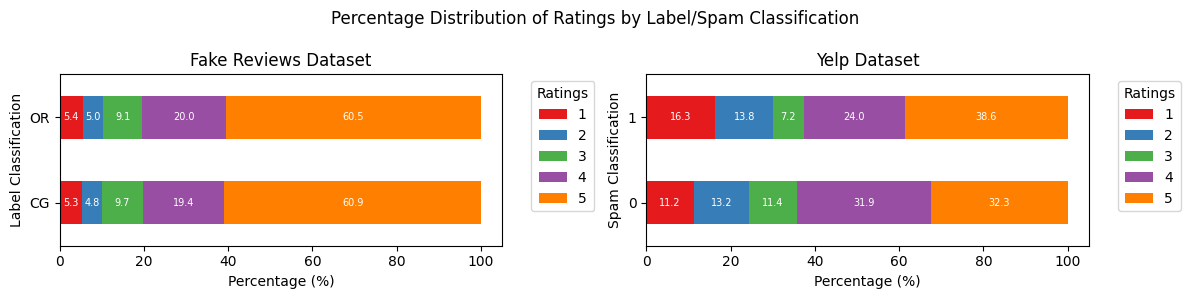

In [34]:
# Calculate the percentage of ratings by label for Fake Reviews
fake_counts = fake_reviews_df.groupby(['label', 'rating']).size().unstack(fill_value=0)
fake_counts = fake_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)

# Calculate the percentage of ratings by spam classification for Yelp
yelp_counts = yelp_df.groupby(['Spam', 'Rating']).size().unstack(fill_value=0)
yelp_counts = yelp_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)

# Set up the plot for both datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
fig.suptitle("Percentage Distribution of Ratings by Label/Spam Classification")

# Plot for Fake Reviews Dataset
fake_counts.plot(kind='barh', stacked=True, color=sns.color_palette("Set1", 5), ax=axes[0])
axes[0].set_title("Fake Reviews Dataset")
axes[0].set_xlabel("Percentage (%)")
axes[0].set_ylabel("Label Classification")
axes[0].legend(title='Ratings', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add white percentage annotations for Fake Reviews
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f', label_type='center', fontsize=7, color='white')

# Plot for Yelp Dataset
yelp_counts.plot(kind='barh', stacked=True, color=sns.color_palette("Set1", 5), ax=axes[1])
axes[1].set_title("Yelp Dataset")
axes[1].set_xlabel("Percentage (%)")
axes[1].set_ylabel("Spam Classification")
axes[1].legend(title='Ratings', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add white percentage annotations for Yelp
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f', label_type='center', fontsize=7, color='white')

plt.tight_layout()
plt.show()


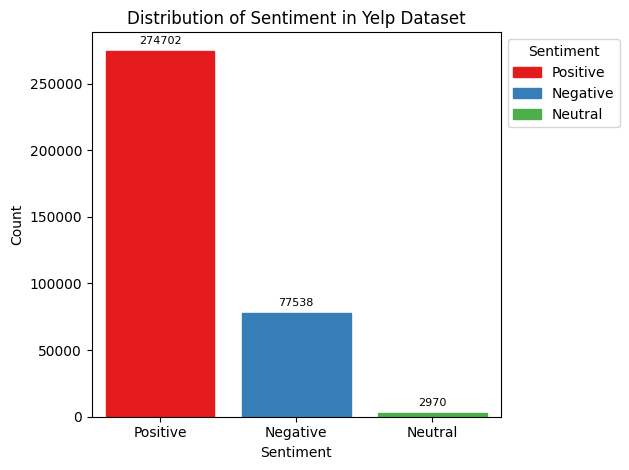

In [35]:
# Check the unique values in 'Sentiment'
unique_sentiments = yelp_df['Sentiment'].unique()

# Create the countplot without 'palette'
ax_yelp = sns.countplot(x='Sentiment', data=yelp_df)

# Manually color each bar using the 'Set1' palette (3 unique colors)
colors_yelp_sentiment = sns.color_palette("Set1", n_colors=3)
for i, bar in enumerate(ax_yelp.patches):
    bar.set_color(colors_yelp_sentiment[i % 3])  # Apply colors cyclically for each sentiment

# Add title and labels
plt.title("Distribution of Sentiment in Yelp Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax_yelp.patches:
    height = p.get_height()
    if height > 0:
        ax_yelp.annotate(f'{height:.0f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='baseline',
                         fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

# Manually create the legend
handles = [mpatches.Patch(color=colors_yelp_sentiment[i], label=unique_sentiments[i]) for i in range(3)]
plt.legend(handles=handles, title='Sentiment', loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.tight_layout()
plt.show()


In [36]:
# Group by Sentiment and Spam, and count the occurrences
sentiment_spam_counts = yelp_df.groupby(['Sentiment', 'Spam']).size().reset_index(name='count')

# Calculate the total count for each sentiment type
sentiment_totals = sentiment_spam_counts.groupby('Sentiment')['count'].transform('sum')

# Calculate the percentage of Spam and Non-Spam within each sentiment type
sentiment_spam_counts['percentage'] = (sentiment_spam_counts['count'] / sentiment_totals) * 100

<Figure size 800x400 with 0 Axes>

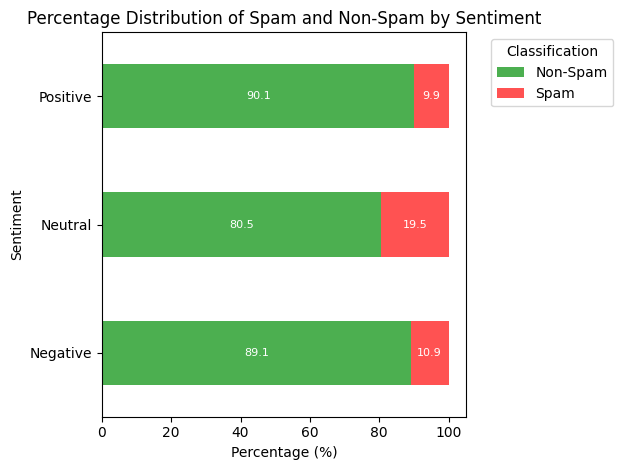

In [37]:
# Set up figure size and style
plt.figure(figsize=(8, 4))

# Create the bar plot with 100% stacking for each sentiment type
sentiment_spam_pivot = sentiment_spam_counts.pivot(index='Sentiment', columns='Spam', values='percentage').fillna(0)
sentiment_spam_pivot.columns = ['Non-Spam', 'Spam']  # Rename columns for readability

# Plotting as a horizontal stacked bar chart
sentiment_spam_pivot.plot(kind='barh', stacked=True, color=['#4CAF50', '#FF5252'])

# Add percentage annotations
for i, (index, row) in enumerate(sentiment_spam_pivot.iterrows()):
    for j, (spam_status, percentage) in enumerate(row.items()):
        if percentage > 0:  # Annotate only non-zero values
            plt.text(percentage / 2 if j == 0 else 100 - (percentage / 2), i,
                     f'{percentage:.1f}', ha='center', va='center', color='white', fontsize=8)

# Labeling and title
plt.xlabel("Percentage (%)")
plt.ylabel("Sentiment")
plt.title("Percentage Distribution of Spam and Non-Spam by Sentiment")
plt.legend(title="Classification", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


## Correlation heatmap between numeric variables in Yelp dataset

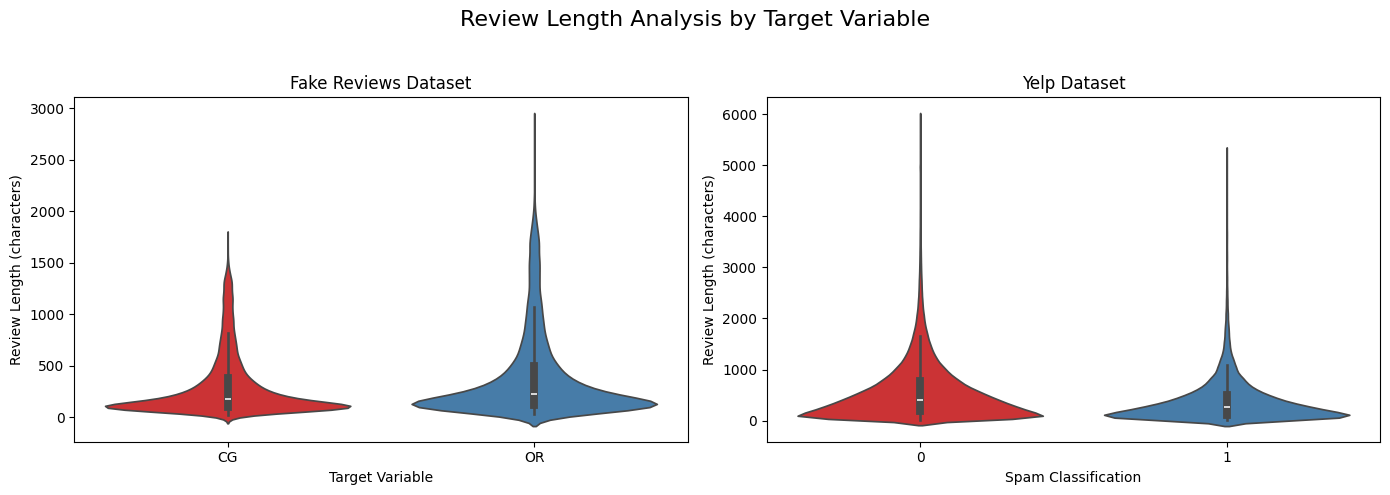

In [38]:
# Calculate review length for each dataset
fake_reviews_df['review_length'] = fake_reviews_df['text_'].str.len()
yelp_df['review_length'] = yelp_df['Review'].str.len()

# Set up the figure and axes for side-by-side plots
plt.figure(figsize=(14, 5))
plt.suptitle("Review Length Analysis by Target Variable", fontsize=16)

# Box plot for Fake Reviews Dataset
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.violinplot(x='label', y='review_length', data=fake_reviews_df, palette='Set1')
plt.title("Fake Reviews Dataset")
plt.xlabel("Target Variable")
plt.ylabel("Review Length (characters)")

# Box plot for Yelp Dataset
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.violinplot(x='Spam', y='review_length', data=yelp_df, palette='Set1')
plt.title("Yelp Dataset")
plt.xlabel("Spam Classification")
plt.ylabel("Review Length (characters)")

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()

In [39]:
yelp_numeric_df = yelp_df.drop(columns=['User_id', 'Product_id'])

# Map sentiment values to numeric codes (adjust mapping as per actual sentiment values)
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
yelp_numeric_df['Sentiment'] = yelp_numeric_df['Sentiment'].map(sentiment_mapping)

yelp_numeric_df.head()

,Rating,Date,Review,Spam,Sentiment,Features,review_length
0,3,2014-01-30,The food at snack is a selection of popular Gr...,1,1,"['appetizer tray', 'greek salad', 'main courses']",215.0
1,3,2011-05-05,This little place in Soho is wonderful. I had ...,1,1,"['little place', 'soho', 'lamb sandwich', 'soh...",269.0
2,4,2011-12-30,ordered lunch for 15 from Snack last Friday. Ã...,1,1,"['snack', 'regular company lunch list']",184.0
3,4,2012-10-04,This is a beautiful quaint little restaurant o...,1,1,"['beautiful quaint', 'pretty street', 'great p...",497.0
4,4,2014-02-06,Snack is great place for a Ã‚Â casual sit down...,1,1,"['snack', 'great place', 'Ã¢ casual', 'cold wi...",611.0


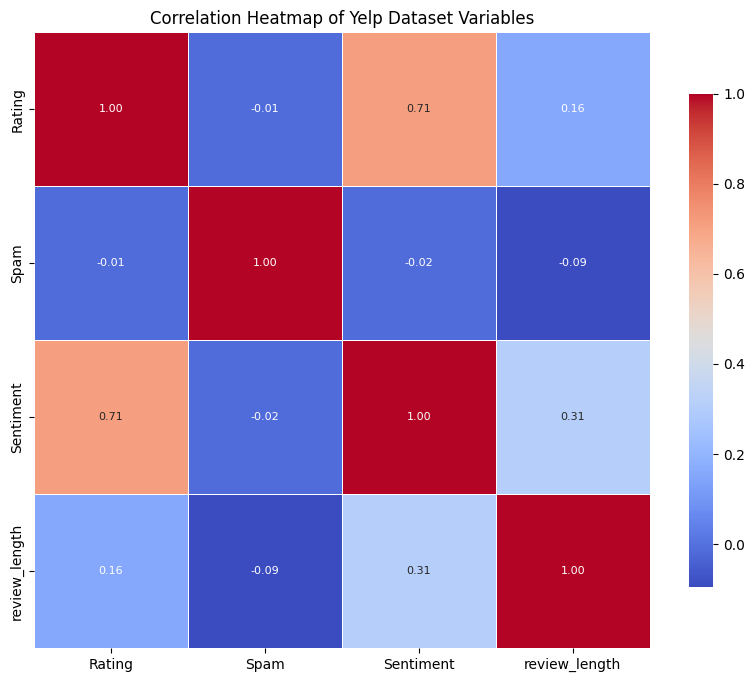

In [40]:
yelp_numeric_cols = yelp_numeric_df.select_dtypes(include='number')

# Calculate the correlation matrix
yelp_corr_matrix = yelp_numeric_cols.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(yelp_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={'shrink': .8}, linewidths=0.5, annot_kws={"size": 8})

# Title for clarity
plt.title("Correlation Heatmap of Yelp Dataset Variables")
plt.show()

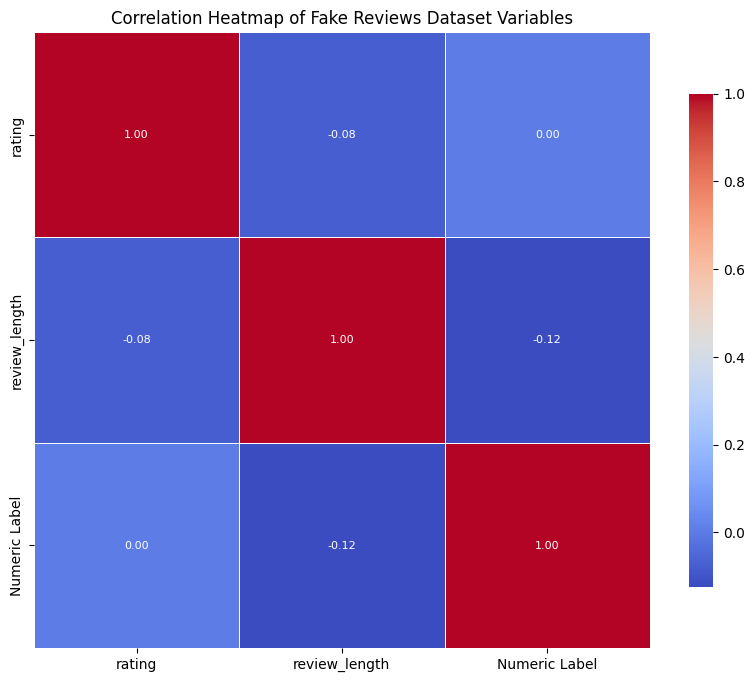

In [41]:
fake_reviews_df['Numeric Label'] = fake_reviews_df['label'].map({'OR': 0, 'CG': 1})

fake_reviews_numeric_cols = fake_reviews_df.select_dtypes(include='number')

# Calculate the correlation matrix
fake_reviews_corr_matrix = fake_reviews_numeric_cols.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(fake_reviews_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={'shrink': .8}, linewidths=0.5, annot_kws={"size": 8})

# Title for clarity
plt.title("Correlation Heatmap of Fake Reviews Dataset Variables")
plt.show()

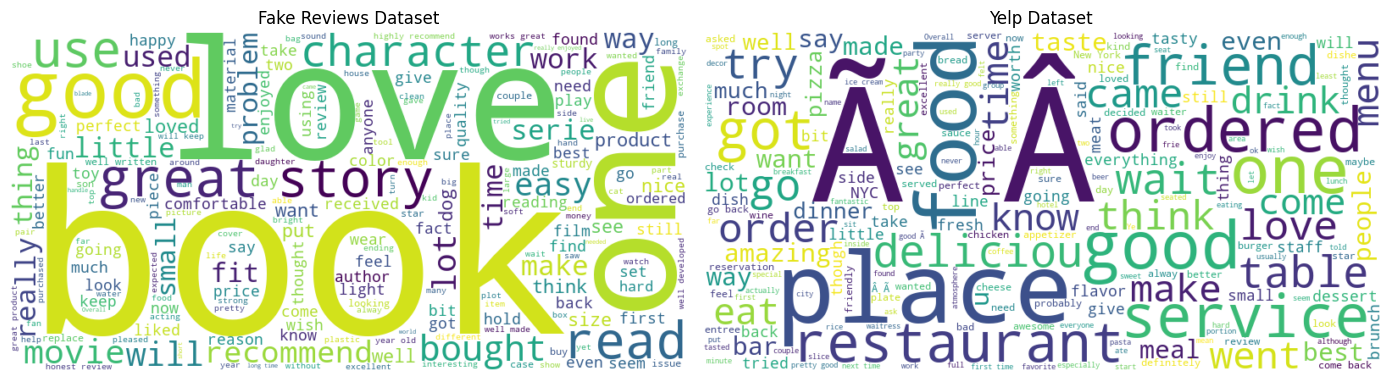

In [42]:
# Combine all reviews into one string for each dataset
fake_reviews_text = " ".join(review for review in fake_reviews_df['text_'].astype(str))
yelp_reviews_text = " ".join(review for review in yelp_df['Review'].astype(str))

# Define stopwords
stopwords = set(STOPWORDS)

# Set up the figure for side-by-side word clouds
plt.figure(figsize=(14, 6))

# Word cloud for Fake Reviews Dataset
plt.subplot(1, 2, 1)
fake_reviews_wordcloud = WordCloud(width=800, height=400, background_color="white",
                                   stopwords=stopwords, colormap="viridis").generate(fake_reviews_text)
plt.imshow(fake_reviews_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Fake Reviews Dataset")

# Word cloud for Yelp Dataset
plt.subplot(1, 2, 2)
yelp_reviews_wordcloud = WordCloud(width=800, height=400, background_color="white",
                                   stopwords=stopwords, colormap="viridis").generate(yelp_reviews_text)
plt.imshow(yelp_reviews_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Yelp Dataset")

# Display the plot
plt.tight_layout()
plt.show()


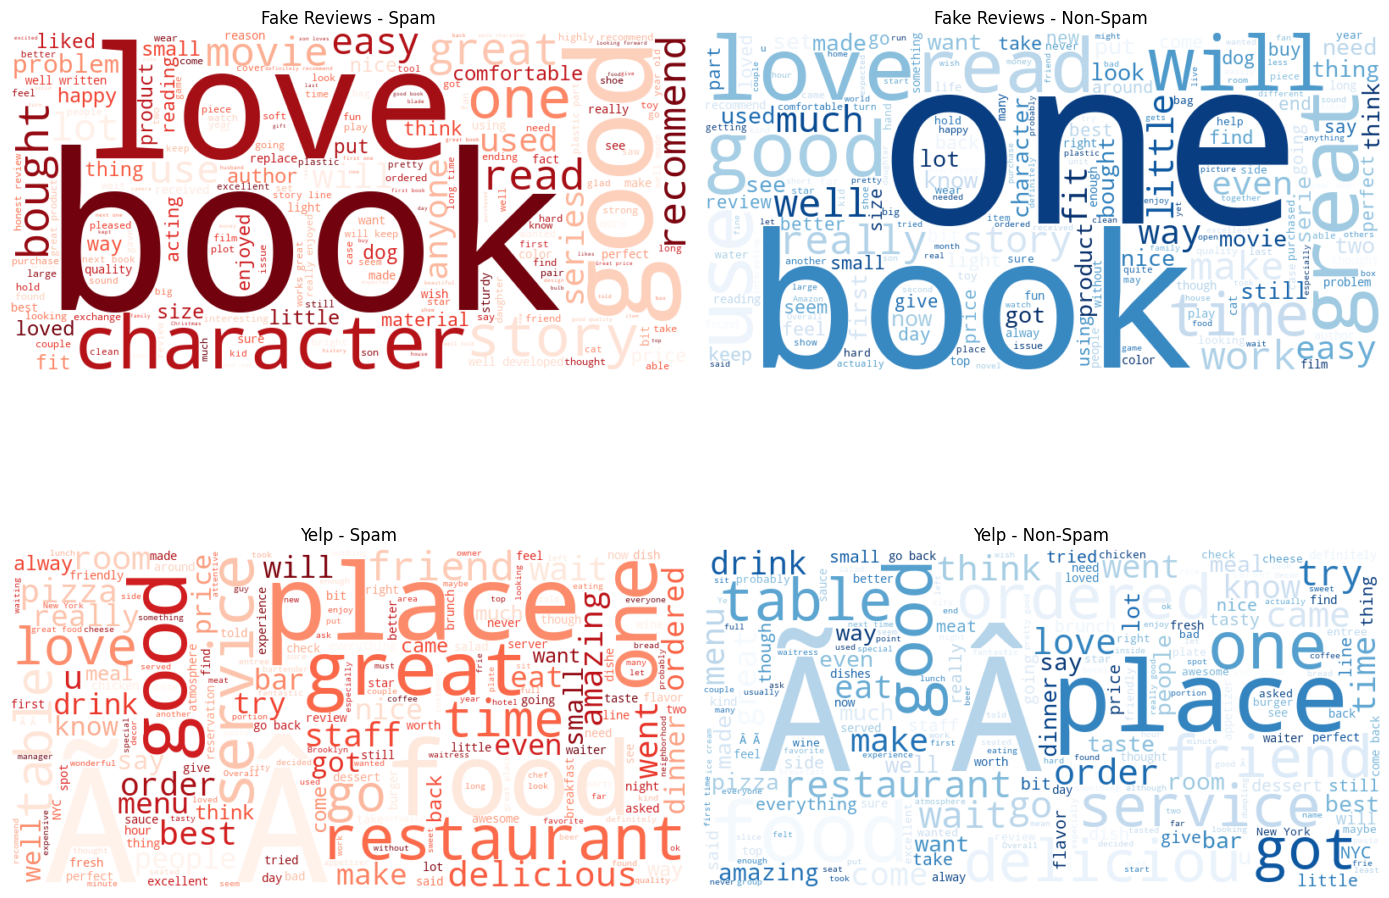

In [43]:
# Define stopwords
stopwords = set(STOPWORDS)

# Separate text based on label/spam classification for both datasets
fake_reviews_text_spam = " ".join(review for review in fake_reviews_df[fake_reviews_df['label'] == 'CG']['text_'].astype(str))
fake_reviews_text_nonspam = " ".join(review for review in fake_reviews_df[fake_reviews_df['label'] == 'OR']['text_'].astype(str))

yelp_reviews_text_spam = " ".join(review for review in yelp_df[yelp_df['Spam'] == 1]['Review'].astype(str))
yelp_reviews_text_nonspam = " ".join(review for review in yelp_df[yelp_df['Spam'] == 0]['Review'].astype(str))

# Set up the figure
plt.figure(figsize=(14, 12))

# Fake Reviews - Spam
plt.subplot(2, 2, 1)
fake_reviews_spam_wordcloud = WordCloud(width=800, height=400, background_color="white",
                                        stopwords=stopwords, colormap="Reds").generate(fake_reviews_text_spam)
plt.imshow(fake_reviews_spam_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Fake Reviews - Spam")

# Fake Reviews - Non-Spam
plt.subplot(2, 2, 2)
fake_reviews_nonspam_wordcloud = WordCloud(width=800, height=400, background_color="white",
                                           stopwords=stopwords, colormap="Blues").generate(fake_reviews_text_nonspam)
plt.imshow(fake_reviews_nonspam_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Fake Reviews - Non-Spam")

# Yelp - Spam
plt.subplot(2, 2, 3)
yelp_spam_wordcloud = WordCloud(width=800, height=400, background_color="white",
                                stopwords=stopwords, colormap="Reds").generate(yelp_reviews_text_spam)
plt.imshow(yelp_spam_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Yelp - Spam")

# Yelp - Non-Spam
plt.subplot(2, 2, 4)
yelp_nonspam_wordcloud = WordCloud(width=800, height=400, background_color="white",
                                   stopwords=stopwords, colormap="Blues").generate(yelp_reviews_text_nonspam)
plt.imshow(yelp_nonspam_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Yelp - Non-Spam")

# Display the plot
plt.tight_layout()
plt.show()

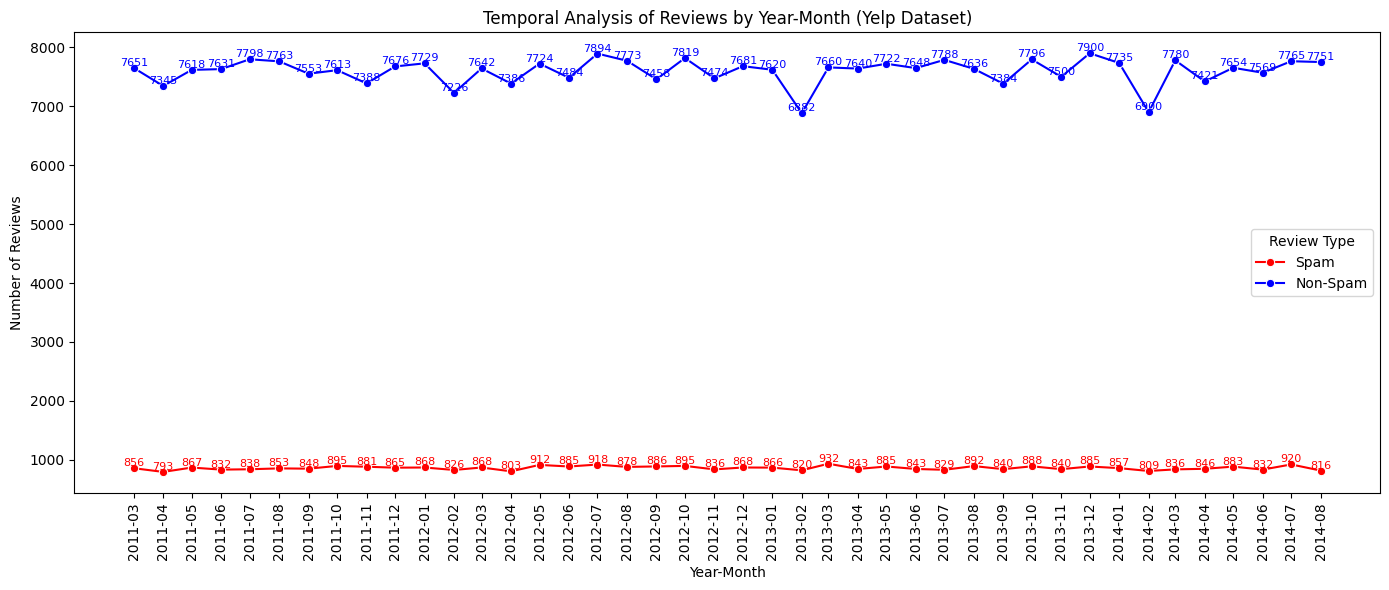

In [44]:
# Extract Year and Month from the 'Date' column
yelp_df['YearMonth'] = yelp_df['Date'].dt.to_period('M')

# Count the number of reviews per month-year, grouped by Spam classification
reviews_per_month_spam = yelp_df[yelp_df['Spam'] == 1].groupby('YearMonth').size()
reviews_per_month_nonspam = yelp_df[yelp_df['Spam'] == 0].groupby('YearMonth').size()

# Convert indices back to a DatetimeIndex for plotting
reviews_per_month_spam.index = reviews_per_month_spam.index.to_timestamp()
reviews_per_month_nonspam.index = reviews_per_month_nonspam.index.to_timestamp()

# Set up the figure
plt.figure(figsize=(14, 6))

# Plot line for Spam reviews
sns.lineplot(x=reviews_per_month_spam.index, y=reviews_per_month_spam.values, 
             marker='o', color='red', label='Spam')
# Plot line for Non-Spam reviews
sns.lineplot(x=reviews_per_month_nonspam.index, y=reviews_per_month_nonspam.values, 
             marker='o', color='blue', label='Non-Spam')

# Add title and labels
plt.title("Temporal Analysis of Reviews by Year-Month (Yelp Dataset)")
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")

# Annotate each point with the review count for Spam
for x, y in zip(reviews_per_month_spam.index, reviews_per_month_spam.values):
    plt.text(x, y, f"{int(y)}", fontsize=8, ha='center', va='bottom', color='red')

# Annotate each point with the review count for Non-Spam
for x, y in zip(reviews_per_month_nonspam.index, reviews_per_month_nonspam.values):
    plt.text(x, y, f"{int(y)}", fontsize=8, ha='center', va='bottom', color='blue')

# Format x-axis to display Year-Month
plt.xticks(reviews_per_month_spam.index, reviews_per_month_spam.index.strftime('%Y-%m'), rotation=90)

# Add legend and layout adjustments
plt.legend(title="Review Type")
plt.tight_layout()
plt.show()
